<h1><center>Gestión de la base de datos</center></h1>

__Objetivo:__ Utilizar la librería de python __"Pandas"__ para, mediante dataframes, gestionar los directorios de los archivos dicom y mhd, y así poder facilitar el entrenamiento de los diferentes modelos.

# Instalaciones

In [ ]:
!pip install pydicom          #Librería para procesar archivos dicom
!pip install SimpleITK        #Librería para procesar archivos mhd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 2.2 MB/s 


# Librerías

In [ ]:
#otros
import os
import re
import cv2
import pickle
import shutil
from glob import glob
from PIL import Image


#basicos
import numpy as np
import pandas as pd

#visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

#tensores
import tensorflow as tf

#sklearn
from sklearn.model_selection import train_test_split

#dicom
import pydicom as dicom

#mhd
import SimpleITK as sitk


# Funciones auxiliares

In [ ]:
#Clase para crear los batches con la info contenida en dataframes.

class DicomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 19),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_name = df[y_col['name']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, dcm_path, target_size):
    
        dicoms=[]
        cont=0
        files_patients=sorted(glob(dcm_path+'/*'))
        dicoms=np.zeros((len(files_patients),)+target_size)
        for file_dcm in files_patients:
          image_array = dicom.dcmread(file_dcm).pixel_array
          image_array = cv2.resize(image_array, target_size[0:2], interpolation=cv2.INTER_NEAREST)  
          dicoms[cont]=image_array/255. 
          cont+=1
        dicoms=np.array(dicoms,dtype='f')
        # dicoms=dicoms.reshape((dicoms.shape[1], dicoms.shape[2],dicoms.shape[0]))
        return dicoms

    def __get_output(self, label, num_classes):
        return np.array(label,dtype='f')
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
              
        name_batch = batches[self.y_col['name']]

        X_batch = np.expand_dims(np.asarray([self.__get_input(x, self.input_size) for x in path_batch]), 1)

        y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])

        return X_batch, y0_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

# Importar dataset

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


### Archivos dicom

In [ ]:
path_db_dicom='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/manifest-A3Y4AE4o5818678569166032044/PROSTATEx' # prostatex dicoms .dcm

In [ ]:
files_patients=sorted(glob(path_db_dicom+'/*'))

In [ ]:
files_patients=[item for item in files_patients if item.split(sep='/')[-1].split(sep='-')[0]=='ProstateX']

In [ ]:
patients=[item.split(sep='/')[-1] for item in files_patients]

In [ ]:
list_aux=sorted(glob(files_patients[25]+'/*'))
for item in list_aux:
  disorder_list=[dicom.split(sep='/')[-1] for dicom in sorted(glob(item+'/*'))]

In [ ]:
files_aux=[]
cont=[]
patients_all=[]
cont=0
for path_file in files_patients:
  list_aux=sorted(glob(path_file+'/*'))
  for item in list_aux:
      disorder_list=[dicom.split(sep='/')[-1] for dicom in sorted(glob(item+'/*'))]
      for i in range(0,len(disorder_list)):
        patients_all.append([patients[cont],disorder_list[i],item+'/'+disorder_list[i]])
  cont+=1
  disorder_list=[]

In [ ]:
df_patients=pd.DataFrame(patients_all)
df_patients.columns =['patients', 'series','path_dcm']

In [ ]:
df_patients=df_patients.assign(s_number=lambda dataset:dataset['series'].apply(lambda row:row.split(sep='.')[0] if row.split(sep='.')[0].isnumeric() 
                                                                                                                else 888), #888 significa que no es un valor numérico
                               s_type=lambda dataset:dataset['series'].apply(lambda row:row.split(sep='-')[1]))

In [ ]:
df_patients['s_number']=df_patients['s_number'].astype('int32')

In [ ]:
df_patients[df_patients['patients']=='ProstateX-0000'].shape

(52, 5)

In [ ]:
df_patients['s_number'].value_counts()

8      347
7      347
26     346
28     346
9      346
      ... 
114      1
115      1
116      1
117      1
109      1
Name: s_number, Length: 116, dtype: int64

In [ ]:
df_patients[df_patients['s_number']==888]

,patients,series,path_dcm,s_number,s_type


In [ ]:
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18321 entries, 0 to 18320
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patients  18321 non-null  object
 1   series    18321 non-null  object
 2   path_dcm  18321 non-null  object
 3   s_number  18321 non-null  int32 
 4   s_type    18321 non-null  object
dtypes: int32(1), object(4)
memory usage: 644.2+ KB


In [ ]:
df_patients['path_dcm'].loc[0]

'/content/drive/MyDrive/Capstone/PROSTATEX_dataset/manifest-A3Y4AE4o5818678569166032044/PROSTATEx/ProstateX-0000/07-07-2011-NA-MR prostaat kanker detectie WDSmc MCAPRODETW-05711/10.000000-tfldynfasttra1.5x1.5t3.5sec-58929'

In [ ]:
df_patients.head(5)

,patients,series,path_dcm,s_number,s_type
0,ProstateX-0000,10.000000-tfldynfasttra1.5x1.5t3.5sec-58929,/content/drive/MyDrive/Capstone/PROSTATEX_data...,10,tfldynfasttra1.5x1.5t3.5sec
1,ProstateX-0000,11.000000-tfldynfasttra1.5x1.5t3.5sec-93717,/content/drive/MyDrive/Capstone/PROSTATEX_data...,11,tfldynfasttra1.5x1.5t3.5sec
2,ProstateX-0000,12.000000-tfldynfasttra1.5x1.5t3.5sec-01678,/content/drive/MyDrive/Capstone/PROSTATEX_data...,12,tfldynfasttra1.5x1.5t3.5sec
3,ProstateX-0000,13.000000-tfldynfasttra1.5x1.5t3.5sec-18051,/content/drive/MyDrive/Capstone/PROSTATEX_data...,13,tfldynfasttra1.5x1.5t3.5sec
4,ProstateX-0000,14.000000-tfldynfasttra1.5x1.5t3.5sec-14900,/content/drive/MyDrive/Capstone/PROSTATEX_data...,14,tfldynfasttra1.5x1.5t3.5sec


In [ ]:
df_patients['s_type'].value_counts()[:20]

tfldynfasttra1.5x1.5t3.5sec                           14435
tfl3d dynamisch fast                                    847
t2tsetra                                                427
t2tsesag                                                370
t2tsecor                                                348
tfl3d PD reftra1.5x1.5t3                                322
ep2ddifftraDYNDIST                                      234
ep2ddifftraDYNDISTADC                                   234
ep2ddifftraDYNDISTCALCBVAL                              234
t2localizer                                             124
t2loc sag                                               122
diffusie                                                 69
ep2ddifftraDYNDISTMIXADC                                 58
ep2ddifftraDYNDISTMIXCALCBVAL                            58
ep2ddifftraDYNDISTMIX                                    58
diff tra b 50 500 800 WIP511b alle spoelen               32
diff tra b 50 500 800 WIP511b alle spoel

Se crea el dataframe patients con la información de las carpetas de cada serie y de cada paciente, así como su respectivo directorio (path_dcm), tipo (s_type) y s_number (número de serie).

#### Exportar dataframe

In [ ]:
path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"df_patients_dcm.pickle","wb")
pickle.dump(df_patients,pickle_out)
pickle_out.close()

### Archivos mhd

In [ ]:
path_db_mhd='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/k_trans' #prostatex ktrans .mhd

In [ ]:
Kt_files_patients=sorted(glob(path_db_mhd+'/*'))
Kt_files_patients[0]

'/content/drive/MyDrive/Capstone/PROSTATEX_dataset/k_trans/ProstateX-0000'

In [ ]:
disorder_list=[]
list_aux=sorted(glob(Kt_files_patients[0]+'/*'))
for mhd in list_aux:
  disorder_list.append(mhd.split(sep='/')[-1])

In [ ]:
files_aux=[]
cont=[]
patients_all_mhd=[]
cont=0
for path_file in Kt_files_patients:
  list_aux=sorted(glob(path_file+'/*'))
  disorder_list=[mhd.split(sep='/')[-1] for mhd in list_aux if mhd.split(sep='.')[-1]=='mhd']
  for i in range(0,len(disorder_list)):
    patients_all_mhd.append([patients[cont],disorder_list[i]])
  cont+=1
  disorder_list=[]

In [ ]:
df_patients_all_mhd=pd.DataFrame(patients_all_mhd,columns=['patient','file'])
df_patients_all_mhd=df_patients_all_mhd.assign(path=path_db_mhd+'/'+df_patients_all_mhd['patient']+'/'+df_patients_all_mhd['file'])

In [ ]:
df_patients_all_mhd.shape

(204, 3)

In [ ]:
df_patients_all_mhd.head()

,patient,file,path
0,ProstateX-0000,ProstateX-0000-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
1,ProstateX-0001,ProstateX-0001-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
2,ProstateX-0002,ProstateX-0002-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
3,ProstateX-0003,ProstateX-0003-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
4,ProstateX-0004,ProstateX-0004-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...


El dataframe df_patients_all_mhd contiene el path de los archivos mhd de cada paciente.

#### Exportar dataframe

In [ ]:
path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"df_patients_all_mhd.pickle","wb")
pickle.dump(df_patients,pickle_out)
pickle_out.close()

#### Visualización de mhd

In [ ]:
query_mhd=df_patients_all_mhd[df_patients_all_mhd['patient']=='ProstateX-0000']
query_mhd['path'][0]

'/content/drive/MyDrive/Capstone/PROSTATEX_dataset/k_trans/ProstateX-0000/ProstateX-0000-Ktrans.mhd'

In [ ]:
# Reads the image using SimpleITK
itkimage = sitk.ReadImage(query_mhd['path'][0])

In [ ]:
# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
ct_scan = sitk.GetArrayFromImage(itkimage)

# Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
origin = np.array(list(reversed(itkimage.GetOrigin())))

# Read the spacing along each dimension
spacing = np.array(list(reversed(itkimage.GetSpacing())))

In [ ]:
ct_scan.shape,origin,spacing

((16, 128, 128), array([-23.9969, -82.1226, -58.4317]), array([3. , 1.5, 1.5]))

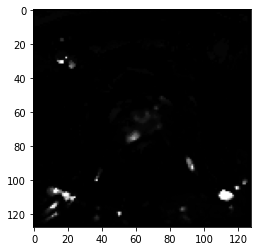

In [ ]:
plt.imshow(ct_scan[6],cmap='gray')
plt.show()

### Datos de entrenamiento dcm

In [ ]:
df_image_train=pd.read_csv('/content/drive/MyDrive/Capstone/Prostatex_info/Prostatex_1/ProstateX-Images-Train.csv',sep=',')

In [ ]:
df_image_train.shape

(3869, 12)

In [ ]:
df_image_train['DCMSerDescr'].value_counts()

ep2d_diff_tra_DYNDIST                            795
t2_tse_tra                                       412
t2_tse_sag                                       358
t2_tse_cor                                       339
tfl_3d PD ref_tra_1.5x1.5_t3                     326
                                                ... 
Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=16.5s       1
Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=15.2s       1
Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=14.0s       1
Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=130.6s      1
Perfusie_t1_twist_1.3x1.3x3_temp_2s_TT=32.8s       1
Name: DCMSerDescr, Length: 130, dtype: int64

In [ ]:
df_image_train.head()

,ProxID,Name,fid,pos,WorldMatrix,ijk,TopLevel,SpacingBetweenSlices,VoxelSpacing,Dim,DCMSerDescr,DCMSerNum
0,ProstateX-0000,ep2d_diff_tra_DYNDIST_ADC0,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST_ADC,7
1,ProstateX-0000,ep2d_diff_tra_DYNDIST0,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
2,ProstateX-0000,ep2d_diff_tra_DYNDIST1,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
3,ProstateX-0000,ep2d_diff_tra_DYNDIST2,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDIST,6
4,ProstateX-0000,ep2d_diff_tra_DYNDISTCALC_BVAL0,1,25.7457 31.8707 -38.511,"2,4.0067e-010,0.00377059,-46.6873,-0.000797221...",36 72 9,1.0,3.0,"2,2,3",84x128x19x1,ep2d_diff_tra_DYNDISTCALC_BVAL,8


In [ ]:
new_df = pd.merge(df_image_train, df_patients,  how='left', left_on=['ProxID','DCMSerNum'], right_on = ['patients','s_number'])


In [ ]:
val_cols=['ProxID','fid','pos','ijk','DCMSerNum','s_number','path_dcm','Name']
new_df=new_df[val_cols]

In [ ]:
new_df.head()

,ProxID,fid,pos,ijk,DCMSerNum,s_number,path_dcm,Name
0,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,7,7,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST_ADC0
1,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,6,6,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST0
2,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,6,6,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST1
3,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,6,6,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST2
4,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,8,8,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDISTCALC_BVAL0


In [ ]:
df_findings1_train=pd.read_csv('/content/drive/MyDrive/Capstone/Prostatex_info/Prostatex_1/ProstateX-Findings-Train.csv',sep=',')

In [ ]:
df_findings1_train.head(5)

,ProxID,fid,pos,zone,ClinSig
0,ProstateX-0000,1,25.7457 31.8707 -38.511,PZ,True
1,ProstateX-0001,1,-40.5367071921656 29.320722668457 -16.70766907...,AS,False
2,ProstateX-0002,1,-27.0102 41.5467 -26.0469,PZ,True
3,ProstateX-0002,2,-2.058 38.6752 -34.6104,PZ,False
4,ProstateX-0003,1,22.1495 31.2717 -2.45933,TZ,False


In [ ]:
df_findings1_train.shape

(330, 5)

In [ ]:
query1=df_findings1_train[(df_findings1_train['ClinSig']==True)]
query1.shape

(76, 5)

In [ ]:
query1['ProxID'].value_counts().shape

(70,)

In [ ]:
query1['ProxID'].value_counts()[:10]

ProstateX-0196    3
ProstateX-0199    2
ProstateX-0203    2
ProstateX-0005    2
ProstateX-0179    2
ProstateX-0121    1
ProstateX-0123    1
ProstateX-0125    1
ProstateX-0126    1
ProstateX-0127    1
Name: ProxID, dtype: int64

In [ ]:
new_df2 = pd.merge(new_df, df_findings1_train,  how='left', left_on=['ProxID','fid'], right_on = ['ProxID','fid'])


In [ ]:
new_df2.head()

,ProxID,fid,pos_x,ijk,DCMSerNum,s_number,path_dcm,Name,pos_y,zone,ClinSig
0,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,7,7,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST_ADC0,25.7457 31.8707 -38.511,PZ,True
1,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,6,6,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST0,25.7457 31.8707 -38.511,PZ,True
2,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,6,6,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST1,25.7457 31.8707 -38.511,PZ,True
3,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,6,6,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDIST2,25.7457 31.8707 -38.511,PZ,True
4,ProstateX-0000,1,25.7457 31.8707 -38.511,36 72 9,8,8,/content/drive/MyDrive/Capstone/PROSTATEX_data...,ep2d_diff_tra_DYNDISTCALC_BVAL0,25.7457 31.8707 -38.511,PZ,True


#### Exportar dataframe

In [ ]:
path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"df_training_dcm.pickle","wb")
pickle.dump(new_df2,pickle_out)
pickle_out.close()

### Datos de entrenamiento mhd

In [ ]:
df_image_train_ktrans=pd.read_csv('/content/drive/MyDrive/Capstone/Prostatex_info/Prostatex_1/ProstateX-Images-KTrans-Train.csv',sep=',')

In [ ]:
df_image_train_ktrans.shape

(335, 5)

In [ ]:
df_image_train_ktrans.head()

,ProxID,fid,pos,WorldMatrix,ijk
0,ProstateX-0000,1,25.7457 31.8707 -38.511,"1.5,3.00503e-010,0.00377059,-58.4317,-0.000597...",56 75 7
1,ProstateX-0001,1,-40.5367071921656 29.320722668457 -16.70766907...,"1.5,3.07655e-010,-4.64581e-017,-116.977,-3.057...",51 61 6
2,ProstateX-0002,1,-27.0102 41.5467 -26.0469,"1.5,3.07655e-010,7.98512e-017,-104.284,-2.9890...",52 73 11
3,ProstateX-0002,2,-2.058 38.6752 -34.6104,"1.5,3.07655e-010,7.98512e-017,-104.284,-2.9890...",68 72 8
4,ProstateX-0003,1,22.1495 31.2717 -2.45933,"1.5,3.07655e-010,3.75383e-017,-98.5005,-2.5684...",80 69 10


In [ ]:
df_patients_all_mhd.head()

,patient,file,path
0,ProstateX-0000,ProstateX-0000-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
1,ProstateX-0001,ProstateX-0001-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
2,ProstateX-0002,ProstateX-0002-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
3,ProstateX-0003,ProstateX-0003-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
4,ProstateX-0004,ProstateX-0004-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...


In [ ]:
new_df3 = pd.merge(df_image_train_ktrans, df_patients_all_mhd,  how='left', left_on=['ProxID'], right_on = ['patient'])

In [ ]:
val_cols=['ProxID','fid','pos','ijk','file','path']
new_df3=new_df3[val_cols]

In [ ]:
new_df3.head()

,ProxID,fid,pos,ijk,file,path
0,ProstateX-0000,1,25.7457 31.8707 -38.511,56 75 7,ProstateX-0000-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
1,ProstateX-0001,1,-40.5367071921656 29.320722668457 -16.70766907...,51 61 6,ProstateX-0001-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
2,ProstateX-0002,1,-27.0102 41.5467 -26.0469,52 73 11,ProstateX-0002-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
3,ProstateX-0002,2,-2.058 38.6752 -34.6104,68 72 8,ProstateX-0002-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...
4,ProstateX-0003,1,22.1495 31.2717 -2.45933,80 69 10,ProstateX-0003-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...


In [ ]:
df_findings1_train.head(5)

,ProxID,fid,pos,zone,ClinSig
0,ProstateX-0000,1,25.7457 31.8707 -38.511,PZ,True
1,ProstateX-0001,1,-40.5367071921656 29.320722668457 -16.70766907...,AS,False
2,ProstateX-0002,1,-27.0102 41.5467 -26.0469,PZ,True
3,ProstateX-0002,2,-2.058 38.6752 -34.6104,PZ,False
4,ProstateX-0003,1,22.1495 31.2717 -2.45933,TZ,False


In [ ]:
df_findings1_train.shape

(330, 5)

In [ ]:
query1=df_findings1_train[(df_findings1_train['ClinSig']==True)]
query1.shape

(76, 5)

In [ ]:
query1['ProxID'].value_counts().shape

(70,)

In [ ]:
query1['ProxID'].value_counts()[:10]

ProstateX-0196    3
ProstateX-0199    2
ProstateX-0203    2
ProstateX-0005    2
ProstateX-0179    2
ProstateX-0121    1
ProstateX-0123    1
ProstateX-0125    1
ProstateX-0126    1
ProstateX-0127    1
Name: ProxID, dtype: int64

In [ ]:
new_df4 = pd.merge(new_df3, df_findings1_train,  how='left', left_on=['ProxID','fid'], right_on = ['ProxID','fid'])

In [ ]:
new_df4.head()

,ProxID,fid,pos_x,ijk,file,path,pos_y,zone,ClinSig
0,ProstateX-0000,1,25.7457 31.8707 -38.511,56 75 7,ProstateX-0000-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...,25.7457 31.8707 -38.511,PZ,True
1,ProstateX-0001,1,-40.5367071921656 29.320722668457 -16.70766907...,51 61 6,ProstateX-0001-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...,-40.5367071921656 29.320722668457 -16.70766907...,AS,False
2,ProstateX-0002,1,-27.0102 41.5467 -26.0469,52 73 11,ProstateX-0002-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...,-27.0102 41.5467 -26.0469,PZ,True
3,ProstateX-0002,2,-2.058 38.6752 -34.6104,68 72 8,ProstateX-0002-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...,-2.058 38.6752 -34.6104,PZ,False
4,ProstateX-0003,1,22.1495 31.2717 -2.45933,80 69 10,ProstateX-0003-Ktrans.mhd,/content/drive/MyDrive/Capstone/PROSTATEX_data...,22.1495 31.2717 -2.45933,TZ,False


#### Exportar dataframe

In [ ]:
path_pickle='/content/drive/MyDrive/Capstone/PROSTATEX_dataset/pickles/'
pickle_out=open(path_pickle+"df_training_mhd.pickle","wb")
pickle.dump(new_df4,pickle_out)
pickle_out.close()